In [15]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as c
from scipy.integrate import quad

In [16]:
cols = ['luminosity_distance', 'mass_1'] # Only taking directly observable values
n_runs = 100   # number of random plots to make
n_m = 100    # resolution of mass points to find max over
n_mc = 15     # number of points to fit for the MCMC
m_cut = 25   # M_sun

# mass_array = np.zeros((n_runs, n_mc))
# d_ls = np.linspace(0, 10000, n_mc) #different DLs to get mass at, units of Mpc
d_ls = np.linspace(0, 5000, n_mc)

In [17]:
with open(f"mass_array_{n_mc}.csv") as file_name:
    array = pd.read_csv(file_name)
# print(array)
mass_array = np.array(array.values)[:,1:]
print(mass_array)

[[32.88475071 35.6251466  39.73574044 ... 72.62049115 76.73108499
  78.10128294]
 [29.25866313 33.75999592 38.26132871 ... 72.02132463 72.02132463
  72.02132463]
 [42.98043657 42.98043657 42.98043657 ... 64.47065486 64.47065486
  64.47065486]
 ...
 [26.54931336 31.85917603 37.1690387  ... 74.3380774  74.3380774
  79.64794008]
 [28.5293664  31.699296   36.4541904  ... 76.07831041 79.24824001
  82.41816961]
 [31.77219667 34.66057818 37.5489597  ... 69.32115636 72.20953788
  75.09791939]]


/home/tanner/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'Om'}>,
        <AxesSubplot:title={'center':'Om'}>],
       [<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'h'}>],
       [<AxesSubplot:title={'center':'m0'}>,
        <AxesSubplot:title={'center':'m0'}>],
       [<AxesSubplot:title={'center':'Ode'}>,
        <AxesSubplot:title={'center':'Ode'}>],
       [<AxesSubplot:title={'center':'om'}>,
        <AxesSubplot:title={'center':'om'}>],
       [<AxesSubplot:title={'center':'ode'}>,
        <AxesSubplot:title={'center':'ode'}>],
       [<AxesSubplot:title={'center':'dH'}>,
        <AxesSubplot:title={'center':'dH'}>],
       [<AxesSubplot:title={'center':'zs'}>,
        <AxesSubplot:title={'center':'zs'}>]], dtype=object)

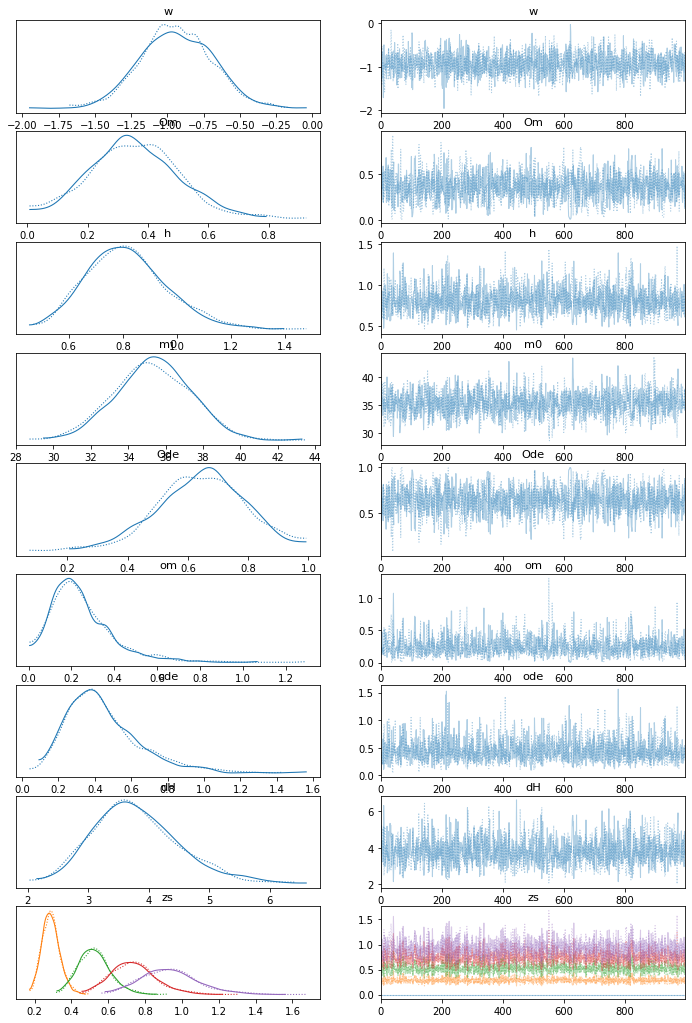

In [18]:
trace_cosmo = az.from_netcdf("O3a-bcosmo.nc")
az.plot_trace(trace_cosmo)

In [19]:
mass_array

array([[32.88475071, 35.6251466 , 39.73574044, ..., 72.62049115,
        76.73108499, 78.10128294],
       [29.25866313, 33.75999592, 38.26132871, ..., 72.02132463,
        72.02132463, 72.02132463],
       [42.98043657, 42.98043657, 42.98043657, ..., 64.47065486,
        64.47065486, 64.47065486],
       ...,
       [26.54931336, 31.85917603, 37.1690387 , ..., 74.3380774 ,
        74.3380774 , 79.64794008],
       [28.5293664 , 31.699296  , 36.4541904 , ..., 76.07831041,
        79.24824001, 82.41816961],
       [31.77219667, 34.66057818, 37.5489597 , ..., 69.32115636,
        72.20953788, 75.09791939]])

In [20]:
mass_mean = np.mean(mass_array, axis=0)
mass_std  = np.std(mass_array, axis=0)
print(mass_mean, mass_std)


[30.15321911 34.13453602 38.01001051 41.89562861 45.72923626 49.53651711
 53.09080296 56.45459425 59.66174394 62.84529536 65.56674616 68.04062942
 70.58379548 73.1547146  75.8888448 ] [5.77816027 4.800351   3.38367137 2.78535948 2.34159442 2.55580098
 3.48178147 3.55933623 3.70170508 4.40027942 4.64970942 5.2179823
 5.93416512 7.15349623 8.72237996]


In [21]:
def d_L(z, h, Ode, Om):
    '''Luminosity distance from redshift assuming flat universe'''
    t_H = ((h*100*(u.km/u.s/u.Mpc))**-1).to(u.s)
    d_H = ((c.c*t_H).to(u.Mpc)).value
    return d_H * quad(lambda x: (Ode + Om*(1+x)**3)**-0.5 ,0, z)[0]

print(d_L(1, 0.7, 0.7, 0.3))

3303.8288058874673


In [22]:
t = trace_cosmo.posterior
t

<xarray.Dataset>
Dimensions:   (chain: 2, draw: 1000, zs_dim_0: 5)
Coordinates:
  * chain     (chain) int64 0 1
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * zs_dim_0  (zs_dim_0) int64 0 1 2 3 4
Data variables:
    w         (chain, draw) float64 -0.5541 -0.6499 -1.319 ... -0.7856 -1.012
    Om        (chain, draw) float64 0.6256 0.5784 0.3687 ... 0.1413 0.4227
    h         (chain, draw) float64 0.8542 0.7842 0.5779 ... 0.7835 0.775 1.0
    m0        (chain, draw) float64 34.55 34.9 39.21 37.25 ... 37.13 36.41 35.14
    Ode       (chain, draw) float64 0.3744 0.4216 0.6313 ... 0.8587 0.5773
    om        (chain, draw) float64 0.4564 0.3557 0.1231 ... 0.08488 0.4227
    ode       (chain, draw) float64 0.2732 0.2593 0.2108 ... 0.5157 0.5774
    dH        (chain, draw) float64 3.51 3.823 5.188 4.248 ... 3.826 3.868 2.998
    zs        (chain, draw, zs_dim_0) float64 0.0 0.3204 0.6004 ... 0.8854 1.126
Attributes:
    created_at:                 2022-06-10T21:38:28.872749
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.0b6
    sampling_time:              7.459936141967773
    tuning_steps:               1000

In [23]:
for var in t.data_vars:
    print(var, t[var].data[0])

w [-0.55414296 -0.64989505 -1.31853805 -1.07421549 -1.11443628 -0.97731975
 -0.921027   -0.66268764 -1.70710694 -0.54386975 -0.50339342 -0.81149888
 -1.02823324 -1.02823324 -1.02823324 -1.02823324 -1.07046116 -0.74441639
 -1.27656552 -0.72592859 -0.93703294 -1.02472682 -0.91679629 -0.75239997
 -0.8620042  -0.58708046 -0.80521388 -0.94413764 -0.75091254 -1.19437976
 -1.17462521 -1.18878672 -1.2773018  -0.96205273 -0.74284323 -0.77997816
 -1.03710513 -0.66306196 -0.9626999  -0.93508706 -0.93427654 -1.15815687
 -1.25775513 -0.63722167 -0.70135175 -0.45023465 -0.7460077  -1.0522337
 -1.00998055 -1.1481143  -1.08591848 -1.19399494 -1.41851019 -0.68148116
 -1.10499931 -1.08756804 -1.15588631 -0.69094763 -0.68299662 -1.25765117
 -1.02743785 -0.59478309 -0.93408358 -1.25464175 -1.25464175 -1.09118815
 -1.16050614 -0.79499593 -1.24882599 -0.7191342  -1.01369716 -0.8399347
 -1.04975695 -1.11296047 -0.95281978 -0.95281978 -0.98346986 -0.88291456
 -1.0549199  -0.78000505 -1.27648045 -1.30036169 -0

In [24]:
for _ in range(100): # Or however many
    const = np.random.choice(t.chain)
    d = np.random.choice(t.draw)
    
    t.zs[const,d,:] # is all the zs from chain c, draw d...

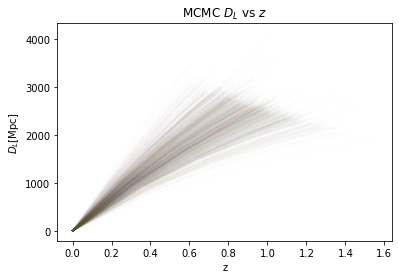

In [25]:
t = trace_cosmo.posterior

for i in range(len(t['zs'].data[0])):

    DLs = [d_L(z, t['h'].data[0,i], t['Ode'].data[0,i], t['Om'].data[0,i]) for z in t['zs'].data[0,i]]

    plot(t['zs'].data[0,i], DLs, alpha=0.01)
xlabel("z")
ylabel(r"$D_L$[Mpc]")
title(r"MCMC $D_L$ vs $z$")
show()

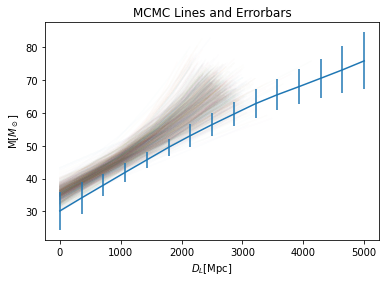

In [26]:

for i in range(len(t['zs'].data[0])):

    DLs = [d_L(z, t['h'].data[0,i], t['Ode'].data[0,i], t['Om'].data[0,i]) for z in t['zs'].data[0,i]]

    plot(DLs, t['m0'].data[0,i]*(1+t['zs'].data[0,i]), alpha=0.01)
    
errorbar(d_ls, mass_mean, mass_std)
xlabel(r"$D_L$[Mpc]")
ylabel(r"M[$M_\odot$]")
# xlim(-200, 6000)
title("MCMC Lines and Errorbars")
show()

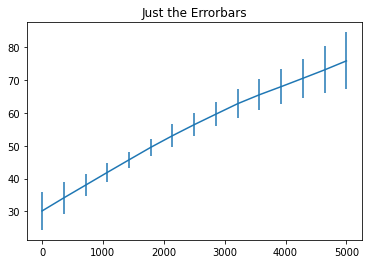

In [27]:
errorbar(d_ls, mass_mean, mass_std)
title("Just the Errorbars")
show()